In [1]:
from shapely.geometry import Point, Polygon
import pandas as pd
import geopandas as gpd
import glob, time
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
gpd.options.use_pygeos = True

In [2]:
def get_input():
    
    '''
    Prompts user for lat, lon input
    and returns a Shapely point
    '''
    
#     point = input("Please, enter a geographical coordinante (lat, lon)" )
    
#     point = point.split(",")
        
#     point = [float(coord.strip()) for coord in point]
    
#     point = Point(point[1], point[0]) # Shapely requires a lon, lat point
    
    point = Point(-46.6598, -23.5318)
    
    return point

In [3]:
def find_user_area(point=None, tracts=None):
    
    '''
    Finds the area that we will need to
    process according to
    '''
    pass

In [4]:
def read_data(path_to_tracts, path_to_shp):
    
    dtype = { 
        
        "CD_GEOCODI": str,
        "CD_GEOCODM": str,
        "CD_MUNICIP": str,
        "Cod_setor": str
        
    }
    
    tracts = pd.read_csv(path_to_tracts, dtype=dtype)
    
    shp = gpd.read_file(path_to_shp, dtype=dtype)
    
    return tracts, shp

In [5]:
def merge_tracts_and_shape(tracts, shp):
    
    return shp.merge(tracts, left_on='CD_GEOCODI', right_on='Cod_setor', how='left')

In [6]:
def covid_count():
    return 739503

In [10]:
def find_radius(point, tracts, spatial_index, target):
    
    ########################
    ### HELPER FUNCTIONS ###
    ########################
    
    def find_intersections(tracts, spatial_index, area):
        '''
        Finds all the polygons that intersect a given radius
        '''
        
        # Uses Geopandas/PyGeos rtree to pre-filter the tracts
        nearby_index = list(spatial_index.intersection(area.bounds))
        
        nearby_tracts = tracts.iloc[nearby_index]
        
        # Selects the tracts that do intersect with the area
        matches = nearby_tracts [ nearby_tracts.geometry.intersects(area)]
        
        return matches
        
                    
    def compute_population_in_area(matches, area):
        '''
        Calculates how many people live in the intersecting polygons.
        Also returns an array with the intersecting shapes.
        '''

        def process_intersection(population, tract, polygon):

            intersection = tract.intersection(polygon)

            intersection_percentage = intersection.area / tract.area 

            population_in_intersection = population * intersection_percentage

            return intersection, population_in_intersection

        intersection, population_in_intersection = process_intersection(matches.populacao_residente.values,
                                         matches.geometry.values,
                                         area)

        matches['geometry'] = intersection
        
        matches['population_in_intersection'] = population_in_intersection

        return matches
    
    #################
    ### EXECUTION ###
    #################
    
    checkpoint = time.time()
    
    total_people = 0
    radius = .001 # This unit is lat/lon degrees
    
    # While we don't meet the population target, we keep increasing the radius to grab more people
    while True:
        
        total_people = 0
        
        area = point.buffer(radius)
        
        matches = find_intersections(tracts, spatial_index, area)
        
        matches = compute_population_in_area(matches, area)
        
        total_people = round(matches.population_in_intersection.sum())
                
        if total_people < target:
        
            radius = radius * 1.5
            
            continue
        
        # Else, finish the iteration
        else:
            
            break
            
    # Now we can move into the fine-tuning, removing excess 
    # population until we are inside a +- 5% tolerance zone
    
    fine_tune = .5

    while True:
        
        if total_people > target * 1.05:
            
            total_people = 0
            
            radius = radius * (1 - fine_tune)
            
            area = point.buffer(radius)
            
            matches = find_intersections(tracts, spatial_index, area)
        
            matches = compute_population_in_area(matches, area)

            total_people = round(matches.population_in_intersection.sum())
            
            if total_people < target * 1.05 and total_people > target * .95:
                
                break 
        
        elif total_people < target * .95:
            
            total_people = 0
            
            radius = radius * (1 + fine_tune)
            
            area = point.buffer(radius)
            
            matches = find_intersections(tracts, spatial_index, area)
        
            matches = compute_population_in_area(matches, area)

            total_people = round(matches.population_in_intersection.sum())
            
            if total_people < target * 1.05 and total_people > target * .95:
                
                break

        
    # After we computed the total area, we can return the matches and see how they look like!
    print(f"Total people: {total_people}")
    print(f"Time computing area: {round(time.time() - checkpoint, 2)}s")
    
    display(matches[["CD_GEOCODI", "geometry", "population_in_intersection"]])
    
    ax = tracts.plot(figsize=(48,42), column="populacao_residente", cmap="Greys")
    ax.axis("off")
    matches.plot(ax=ax, column="population_in_intersection", cmap='Reds', alpha=.5)

In [11]:
def main():
    
    # Gets input from user and turns it into a shapely point
    point = get_input()
    
    # TO DO: figure out a way of detecting which data we need to load
    find_user_area(point)
    
    # Reads the data
    tracts, shp = read_data("../data/censo_dados_resumidos.csv", "../data/setores_censitarios_shp_reduzido/")
    
    # Merge it into a single dataframe
    gdf = merge_tracts_and_shape(tracts, shp)
    
    # Remove unneeded variables
    del tracts, shp
        
    # Uses a buffer to avoid self-intercepting shapes
    gdf["geometry"] = gdf.geometry.buffer(0)
        
    # Temporary: test with São Paulo
    # gdf = gdf [ gdf.CD_GEOCODM == "3550308" ]
        
    # TO DO: discover how many covid-19 deaths we have at this point in time
    target = covid_count()
    
    # Creates a sindex to improve search
    spatial_index = gdf.sindex
        
    # Finds the area that we will need to highlight along with the respective population
    find_radius(point, gdf, spatial_index, target)
    
    
    # Saves it as geojson
    pass
    
    # Returns
    pass

Total people: 747432.0
Time computing area: 2.05s


,CD_GEOCODI,geometry,population_in_intersection
61959,355030845000045,"POLYGON ((-46.66510 -23.57247, -46.66499 -23.5...",52.027246
61984,355030845000070,"POLYGON ((-46.66369 -23.57266, -46.66316 -23.5...",42.748842
62027,355030845000113,"POLYGON ((-46.65868 -23.57280, -46.65848 -23.5...",8.215058
58984,355030832000068,"POLYGON ((-46.65386 -23.57237, -46.65357 -23.5...",4.409452
62052,355030845000138,"POLYGON ((-46.65693 -23.57230, -46.65653 -23.5...",65.461631
...,...,...,...
63092,355030850000017,"MULTIPOLYGON (((-46.67168 -23.49311, -46.67170...",166.463212
56150,355030821000111,"POLYGON ((-46.66274 -23.49089, -46.66272 -23.4...",329.403902
56134,355030821000095,"POLYGON ((-46.66665 -23.49154, -46.66662 -23.4...",135.893638
63132,355030850000057,"POLYGON ((-46.66651 -23.49134, -46.66662 -23.4...",25.166249


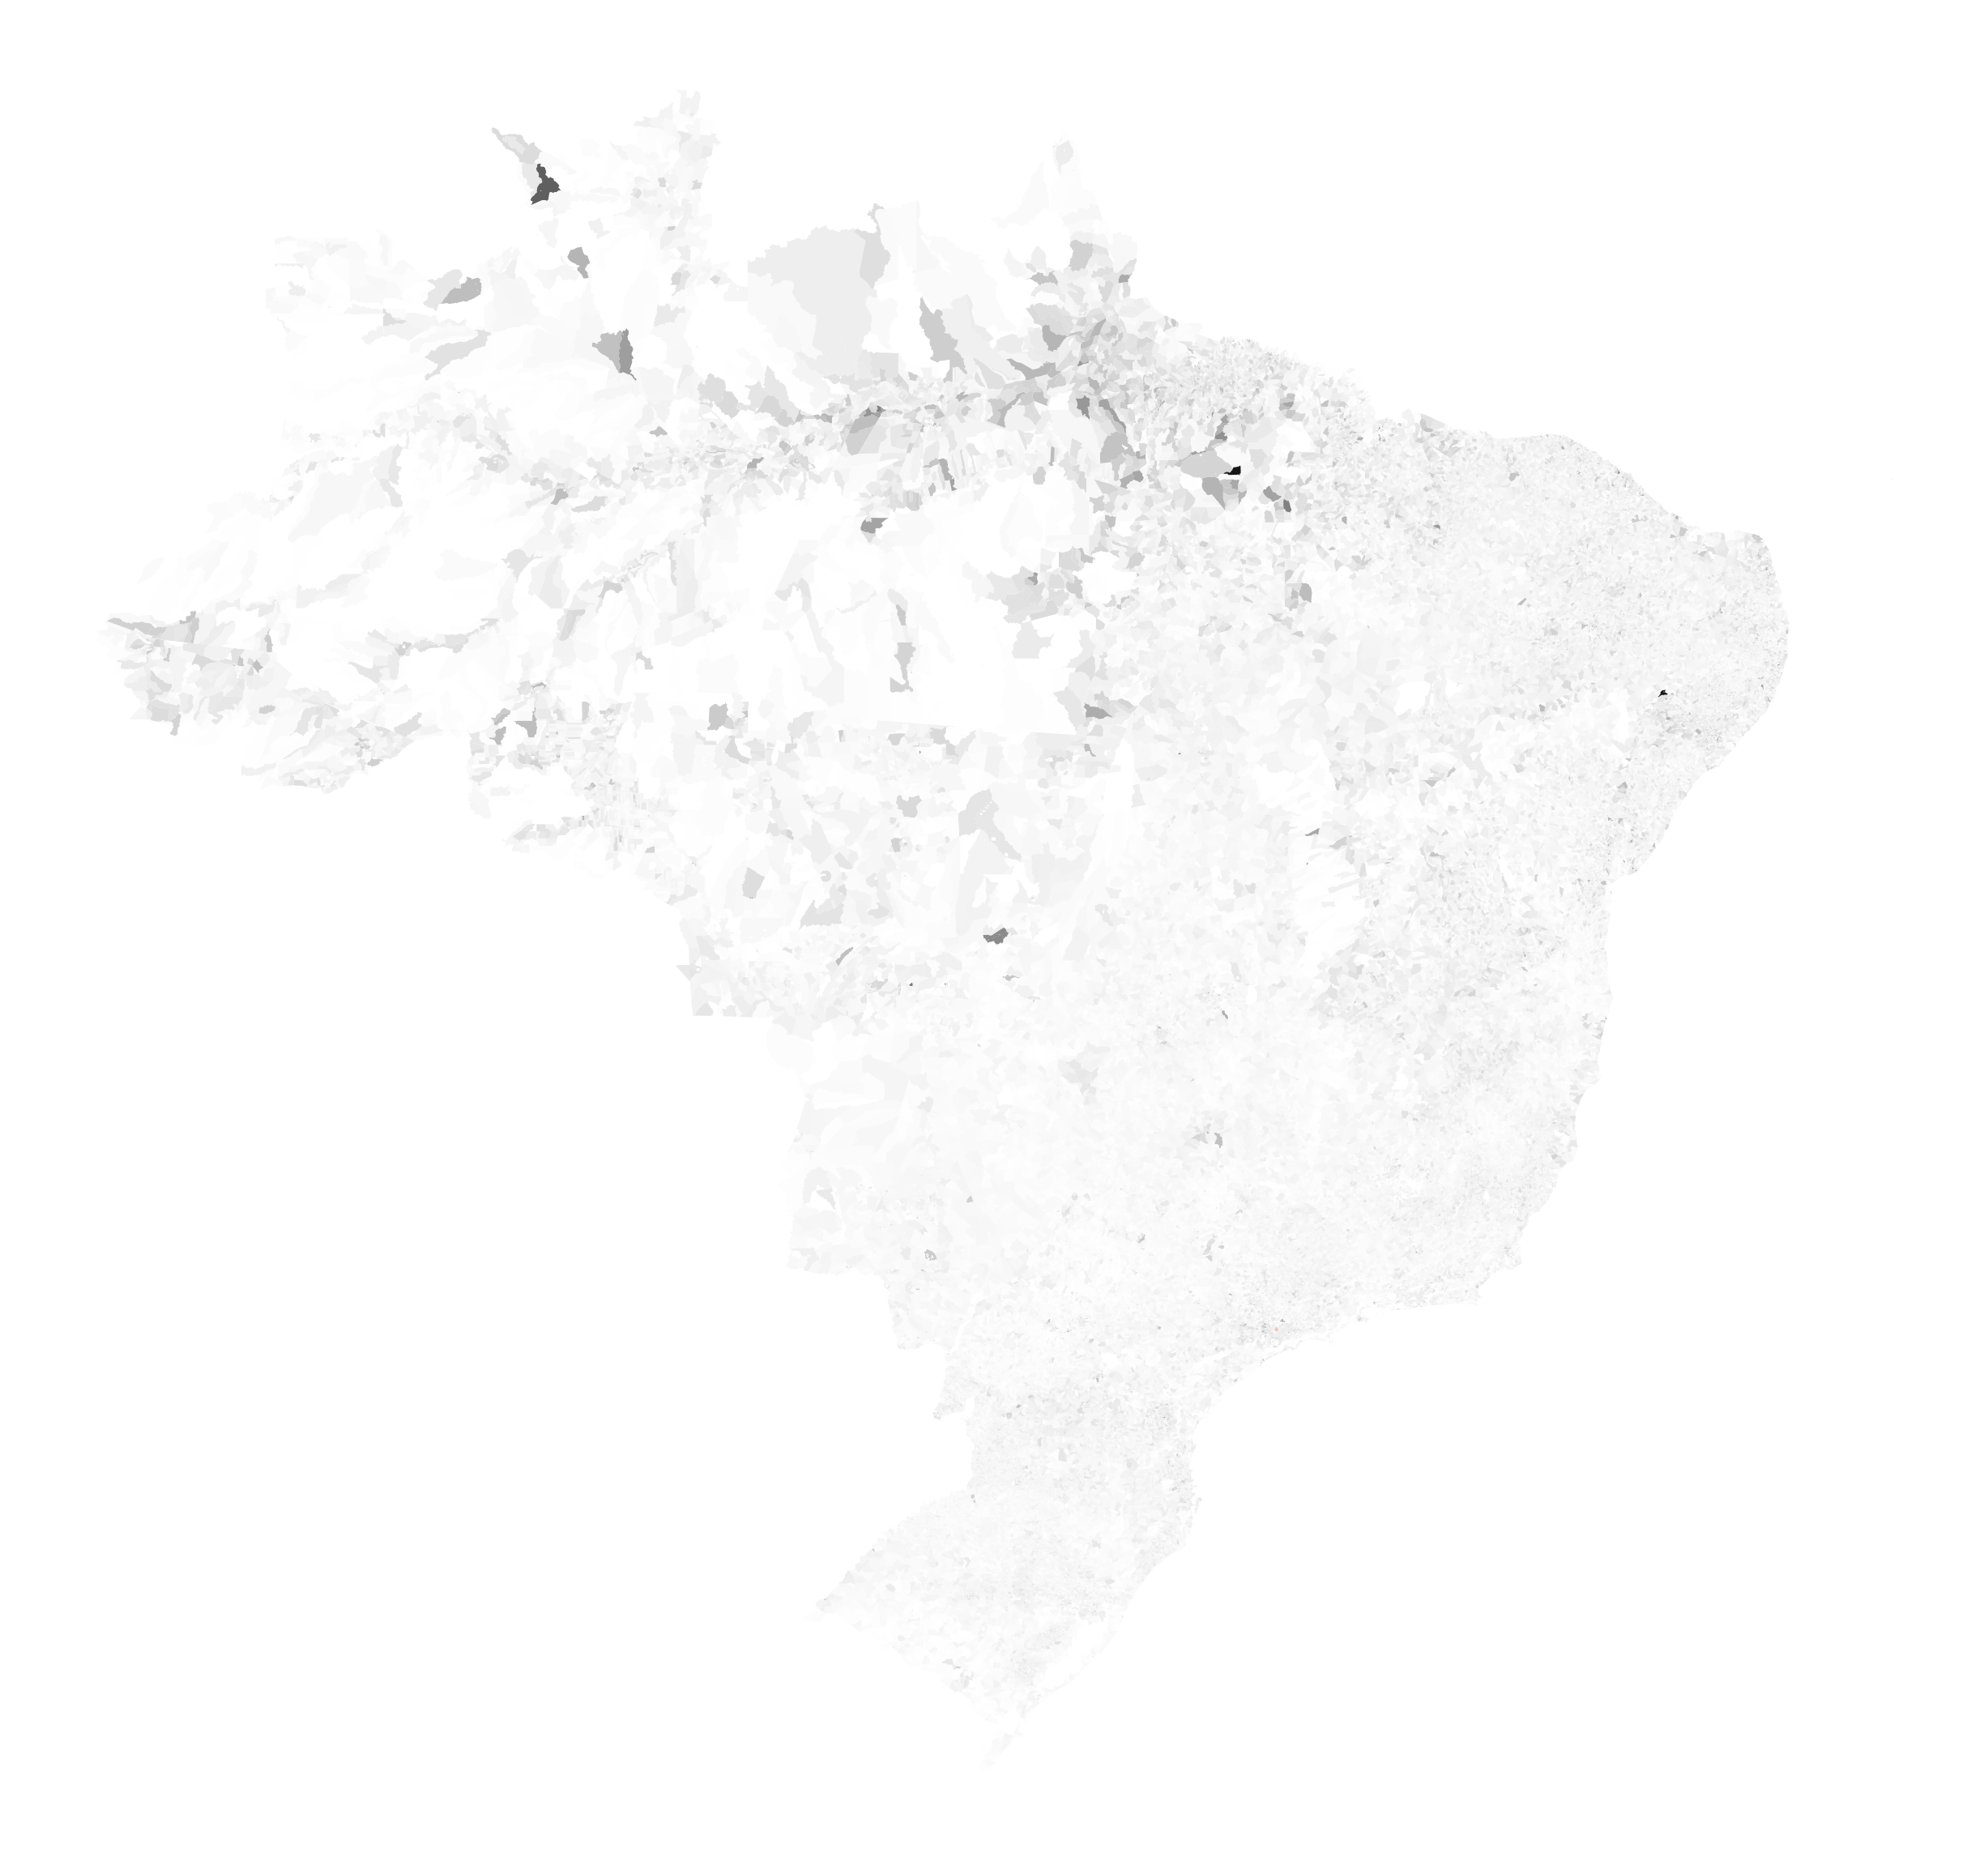

In [12]:
if __name__ == "__main__":
    main()